# Machin Learning with R
From [Your First Machine Learning Projet in R](https://machinelearningmastery.com/machine-learning-in-r-step-by-step/)

Let’s evaluate 5 different algorithms on Iris data:
- **Linear Discriminant Analysis (LDA)**
- Classification and Regression Trees (CART).
- k-Nearest Neighbors (kNN).
- Support Vector Machines (SVM) with a linear kernel.
- Random Forest (RF)


## 1. Our Data
_____________
We will use the **dataset Iris**

### 1.1 Load CSV

In [1]:
filename <- "iris.csv"
# load the CSV file from the local directory
dataset <- read.csv(filename, header=FALSE)
# set the column names in the dataset
colnames(dataset) <- c("Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species")

### 1.2 Know our data

In [2]:
sapply(dataset, class) # list types for each attribute
dim(dataset) # size
head(dataset)
summary(dataset)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width      Species 
   "numeric"    "numeric"    "numeric"    "numeric"     "factor"

[1] 150   5

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa


  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
            Species  
 Iris-setosa    :50  
 Iris-versicolor:50  
 Iris-virginica :50  
                     
                     
                     

## 2. Create Data Partition
______________
Split Iris data in 1 partition for training ML and 1 partition for ML validation.
- Training partition 80% of Iris data
- Validation partition 20% of Iris data

### 2.1 Split

In [3]:
library(lattice)
library(ggplot2)
library(caret)
# create a list of 80% of the rows in the original dataset we can use for training
validation_index <- createDataPartition(dataset$Species, p=0.80, list=FALSE)
# select 20% of the data for validation
validation <- dataset[-validation_index,]
# use the remaining 80% of data to training and testing the models
dataset <- dataset[validation_index,]

cat(
    "Training partition: ",dim(dataset)[1],"\n",
    "Validation partition: ",dim(validation)[1]
)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Training partition:  120 
 Validation partition:  30

### 2.2 Info on Training Partition dataset

In [4]:
# list the levels for the class
levels(dataset$Species)

[1] "Iris-setosa"     "Iris-versicolor" "Iris-virginica"

In [5]:
# summarize the class distribution
percentage <- prop.table(table(dataset$Species)) * 100
cbind(freq=table(dataset$Species), percentage=percentage)

,freq,percentage
Iris-setosa,40,33.33333
Iris-versicolor,40,33.33333
Iris-virginica,40,33.33333


In [6]:
summary(dataset)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.575   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.300   Median :1.300  
 Mean   :5.825   Mean   :3.049   Mean   :3.747   Mean   :1.192  
 3rd Qu.:6.400   3rd Qu.:3.325   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.700   Max.   :2.500  
            Species  
 Iris-setosa    :40  
 Iris-versicolor:40  
 Iris-virginica :40  
                     
                     
                     

### 2.3 Visualization
#### 2.3.1 Univariate Plots
A plots of each individual variable.

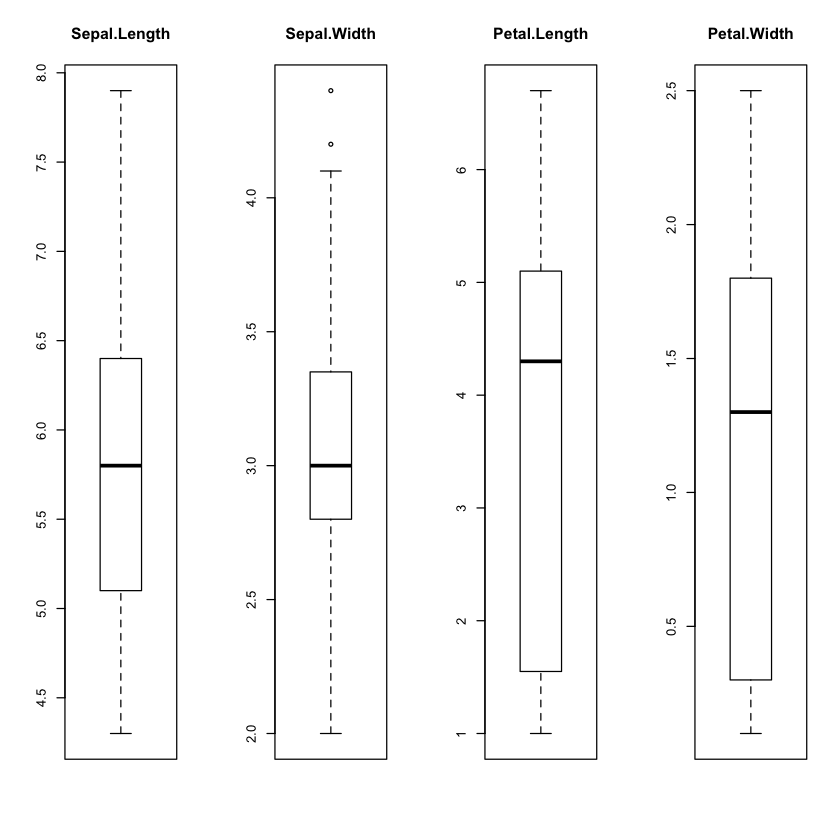

In [7]:
# split input and output
x <- dataset[,1:4]
y <- dataset[,5]

# boxplot for each attribute on one image
par(mfrow=c(1,4))
  for(i in 1:4) {
  boxplot(x[,i], main=names(iris)[i])
}

#### 2.3.2 Simple count of Species in a Barplot

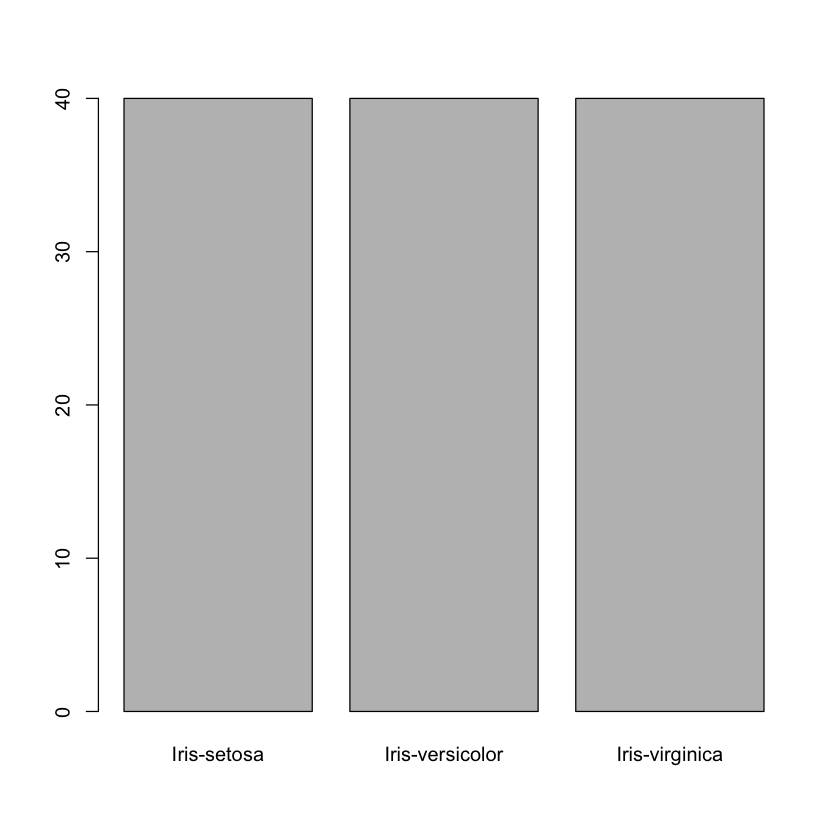

In [8]:
# barplot for class breakdown
plot(y)

#### 2.3.3 Multivariate Plots
Show the interactions between the variables with ellipses.


Attaching package: ‘ellipse’

The following object is masked from ‘package:graphics’:

    pairs



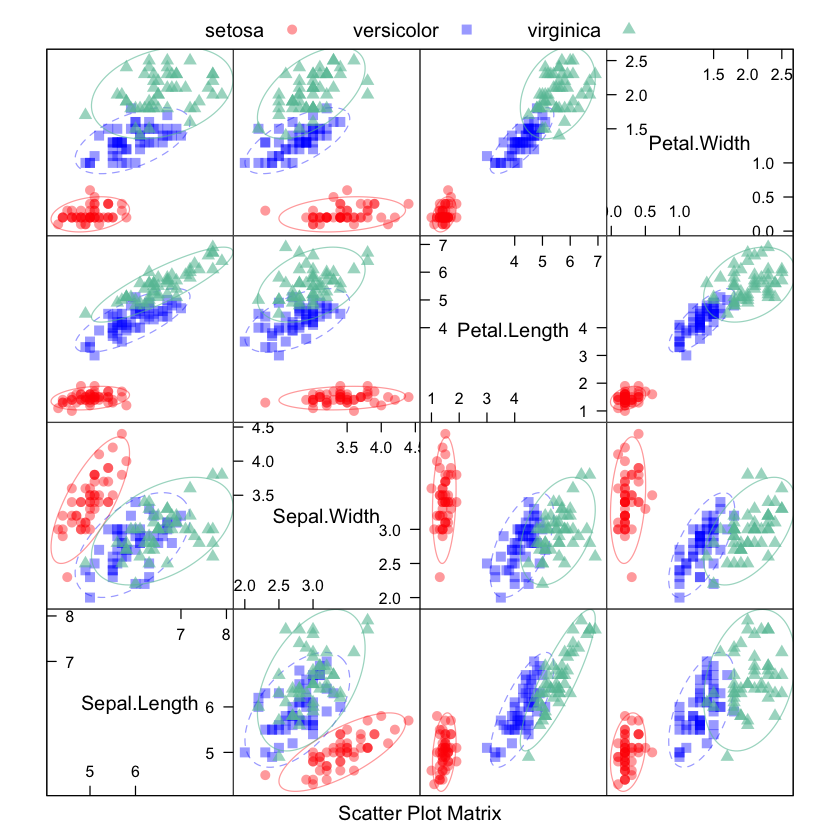

In [9]:
library(ellipse)
library(AppliedPredictiveModeling)
transparentTheme(trans = .4)
featurePlot(x = iris[, 1:4], 
            y = iris$Species, 
            plot = "ellipse",
            ## Add a key at the top
            auto.key = list(columns = 3))

#### 2.3.4 Whisker Plots of variables
This is useful to see that there are clearly different distributions of the attributes for each class value.

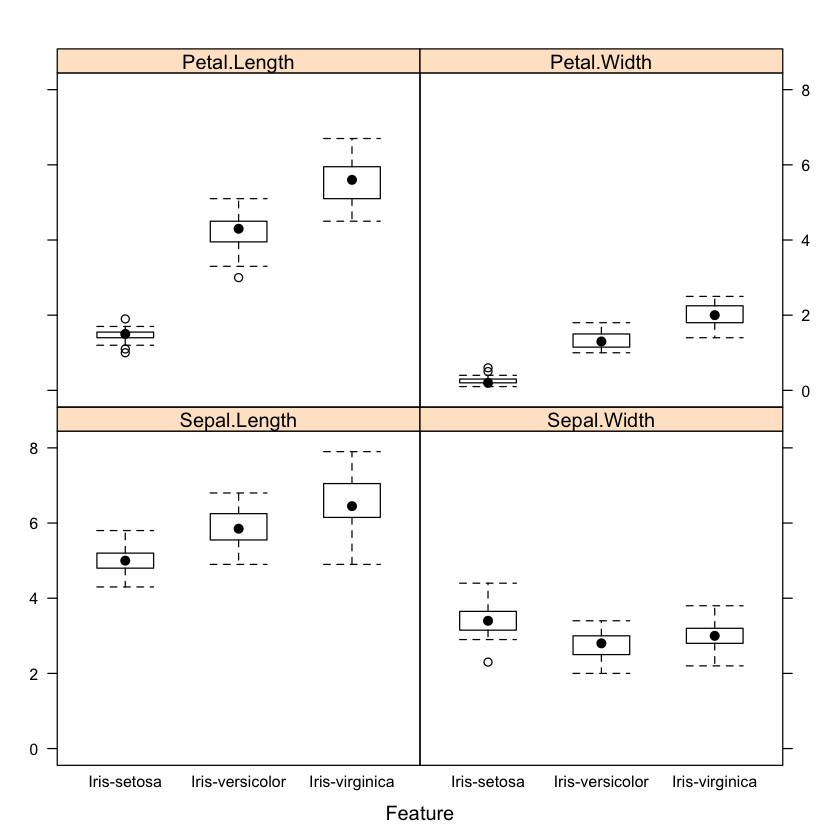

In [10]:
# box and whisker plots for each attribute
featurePlot(x=x, y=y, plot="box")

#### 2.3.5 Histograms distribution density plots
We can see the Gaussian-like distribution (bell curve) of each attribute.

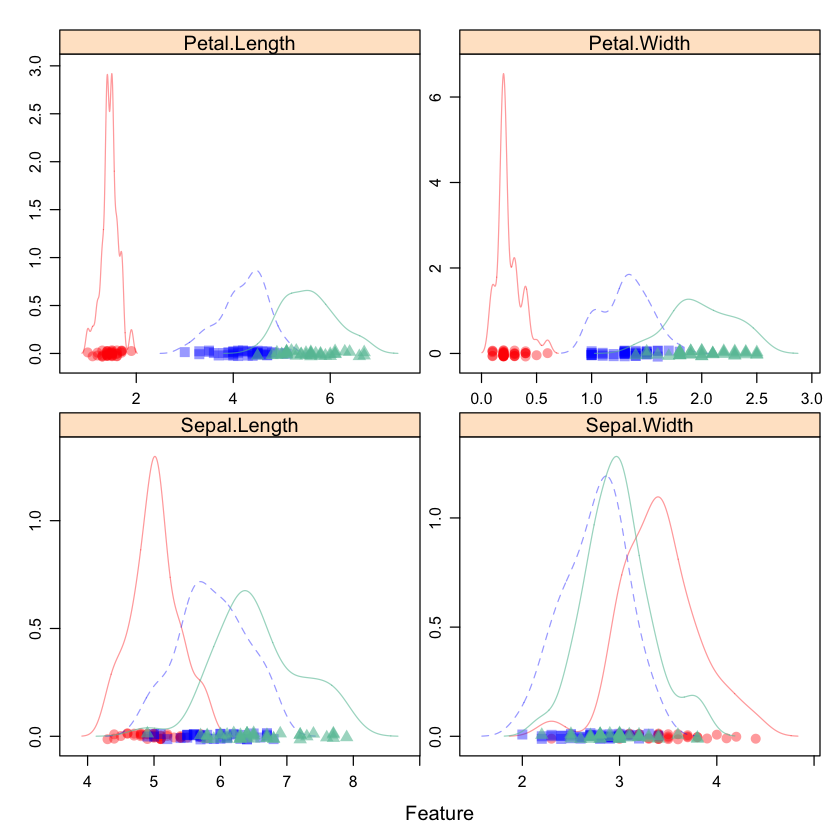

In [11]:
# density plots for each attribute by class value
scales <- list(x=list(relation="free"), y=list(relation="free"))
featurePlot(x=x, y=y, plot="density", scales=scales)

## 3. Find the ML Model
_______________
### 3.1 Test Harness
This will split our dataset into 10 parts, train in 9 and test on 1 and release for all combinations of train-test splits. We will also repeat the process 3 times for each algorithm with different splits of the data into 10 groups, in an effort to get a more accurate estimate.

We are using the metric of “Accuracy” to evaluate models. This is a ratio of the number of correctly predicted instances in divided by the total number of instances in the dataset multiplied by 100 to give a percentage (e.g. 95% accurate). We will be using the metric variable when we run build and evaluate each model next.

In [12]:
# Run algorithms using 10-fold cross validation
control <- trainControl(method="cv", number=10)
metric <- "Accuracy"

Let’s evaluate 5 different algorithms:
- Linear Discriminant Analysis (LDA)
- Classification and Regression Trees (CART).
- k-Nearest Neighbors (kNN).
- Support Vector Machines (SVM) with a linear kernel.
- Random Forest (RF)

This is a good mixture of simple linear (LDA), nonlinear (CART, kNN) and complex nonlinear methods (SVM, RF). We reset the random number seed before reach run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. It ensures the results are directly comparable.

### 3.2 Builds models

In [13]:
# a) linear algorithms
set.seed(7)
fit.lda <- train(Species~., data=dataset, method="lda", metric=metric, trControl=control)
# b) nonlinear algorithms
# CART
set.seed(7)
fit.cart <- train(Species~., data=dataset, method="rpart", metric=metric, trControl=control)
# kNN
set.seed(7)
fit.knn <- train(Species~., data=dataset, method="knn", metric=metric, trControl=control)
# c) advanced algorithms
# SVM
set.seed(7)
fit.svm <- train(Species~., data=dataset, method="svmRadial", metric=metric, trControl=control)
# Random Forest
set.seed(7)
fit.rf <- train(Species~., data=dataset, method="rf", metric=metric, trControl=control)

### 3.3 Test Models

In [14]:
# summarize accuracy of models
results <- resamples(list(lda=fit.lda, cart=fit.cart, knn=fit.knn, svm=fit.svm, rf=fit.rf))
summary(results)


Call:
summary.resamples(object = results)

Models: lda, cart, knn, svm, rf 
Number of resamples: 10 

Accuracy 
          Min.   1st Qu.    Median      Mean 3rd Qu. Max. NA's
lda  0.9166667 0.9375000 1.0000000 0.9750000       1    1    0
cart 0.8333333 0.9166667 0.9583333 0.9500000       1    1    0
knn  0.8333333 0.9166667 1.0000000 0.9583333       1    1    0
svm  0.7500000 0.9166667 0.9583333 0.9416667       1    1    0
rf   0.8333333 0.9166667 0.9583333 0.9500000       1    1    0

Kappa 
      Min. 1st Qu. Median   Mean 3rd Qu. Max. NA's
lda  0.875 0.90625 1.0000 0.9625       1    1    0
cart 0.750 0.87500 0.9375 0.9250       1    1    0
knn  0.750 0.87500 1.0000 0.9375       1    1    0
svm  0.625 0.87500 0.9375 0.9125       1    1    0
rf   0.750 0.87500 0.9375 0.9250       1    1    0


### 3.4 Plot Results
We create a plot of the model evaluation results and compare the spread and the mean accuracy of each model. There is a population of accuracy measures for each algorithm because each algorithm was evaluated 10 times (10 fold cross validation).

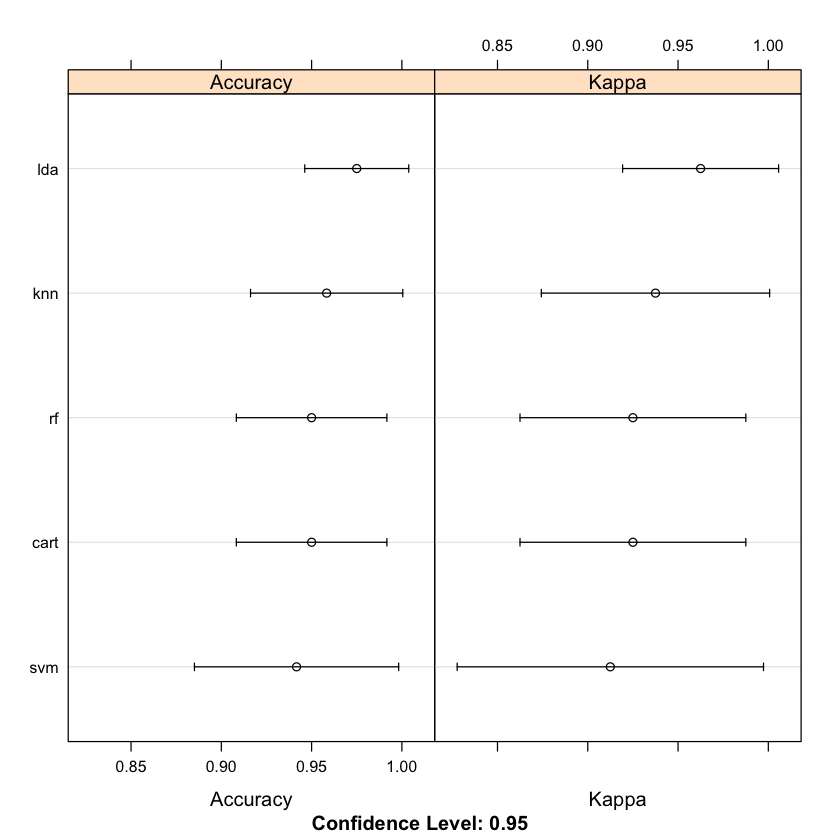

In [15]:
# compare accuracy of models
dotplot(results)

Best Accurancy model here: LDA
## 4. Linear Discriminant Analysis
_____________
### 4.1 Summarize LDA Model

In [16]:
# summarize Best Model
print(fit.lda)

Linear Discriminant Analysis 

120 samples
  4 predictor
  3 classes: 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 108, 108, 108, 108, 108, 108, ... 
Resampling results:

  Accuracy  Kappa 
  0.975     0.9625



This gives a nice summary of what was used to train the model and the mean and standard deviation (SD) accuracy achieved, specifically:
- **97.5% accuracy +/- 4%**

### 4.2 Check accurancy

Predictions vs Validation, accuracy 100%.

In [17]:
# estimate skill of LDA on the validation dataset
predictions <- predict(fit.lda, validation[,1:4])
confusionMatrix(predictions, validation$Species)

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              10               0              0
  Iris-versicolor           0              10              0
  Iris-virginica            0               0             10

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.8843, 1)
    No Information Rate : 0.3333     
    P-Value [Acc > NIR] : 4.857e-15  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 1.0000
Specificity                      1.0000                 1.0000
Pos Pred Value                   1.0000                 1.0000
Neg Pred Value                   1.0000                 1.0

### 4.3 Show Predictions results

In [18]:
# add Predictions column to validation
validation$Predictions <- predictions

# add column Same
validation$Same <- ifelse(validation$Species == validation$Predictions, 'TRUE',
               ifelse(validation$Species != df$Predictions, 'FALSE'))

validation

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,Predictions,Same
4,4.6,3.1,1.5,0.2,Iris-setosa,Iris-setosa,TRUE
10,4.9,3.1,1.5,0.1,Iris-setosa,Iris-setosa,TRUE
12,4.8,3.4,1.6,0.2,Iris-setosa,Iris-setosa,TRUE
17,5.4,3.9,1.3,0.4,Iris-setosa,Iris-setosa,TRUE
28,5.2,3.5,1.5,0.2,Iris-setosa,Iris-setosa,TRUE
37,5.5,3.5,1.3,0.2,Iris-setosa,Iris-setosa,TRUE
39,4.4,3.0,1.3,0.2,Iris-setosa,Iris-setosa,TRUE
45,5.1,3.8,1.9,0.4,Iris-setosa,Iris-setosa,TRUE
47,5.1,3.8,1.6,0.2,Iris-setosa,Iris-setosa,TRUE
48,4.6,3.2,1.4,0.2,Iris-setosa,Iris-setosa,TRUE


#### Predictions on new data

In [19]:
df <- data.frame (Sepal.Length  = c(5, 5.8),
                  Sepal.Width = c(3.6, 2.7),
                  Petal.Length = c(1.4, 5.1),
                  Petal.Width = c(0.2, 1.9)
                  )
df

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
5.0,3.6,1.4,0.2
5.8,2.7,5.1,1.9


In [20]:
p <- predict(fit.lda, df)
df$Predictions <- p
df

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Predictions
5.0,3.6,1.4,0.2,Iris-setosa
5.8,2.7,5.1,1.9,Iris-virginica
